In [1]:
import copy
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np

import os
from PIL import Image

from scipy import linalg
import scipy.io

import torch
import torchvision.models as tvm
from torchvision import transforms
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch.utils.data as data
import json
from tqdm.notebook import tqdm
%matplotlib inline
plt.xkcd()

torch.manual_seed(1337)
np.random.seed(1337)

In [2]:
def get_flower_dataset(data_dir = './datasets/flower_data'):
    data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomRotation(45),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
             ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
             ])
        }


    image_datasets = {
            x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
            for x in list(data_transforms.keys())
        }

    dataloaders = {
            x: data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=12)
            for x in list(image_datasets.keys())
        }
    dataset_sizes = {
            x: len(dataloaders[x].dataset) 
            for x in list(image_datasets.keys())
        } 
    class_names = image_datasets['train'].classes


    with open(data_dir + '/cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
    # changing categories to their actual names 
    for i in range(0,len(class_names)):
        class_names[i] = cat_to_name.get(class_names[i])
    return dataloaders, dataset_sizes, class_names

In [3]:
def get_birds_dataset(data_dir = './datasets/birds_data'):
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.RandomRotation(45),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # loading datasets with PyTorch ImageFolder
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    # defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=12)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    class_names = image_datasets['train'].classes
    return dataloaders, dataset_sizes, class_names


In [4]:
def get_stanford_dataset(data_dir = './datasets/stanford_data'):
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.RandomRotation(45),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # loading datasets with PyTorch ImageFolder
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    # defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=12)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    class_names = image_datasets['train'].classes
    return dataloaders, dataset_sizes, class_names

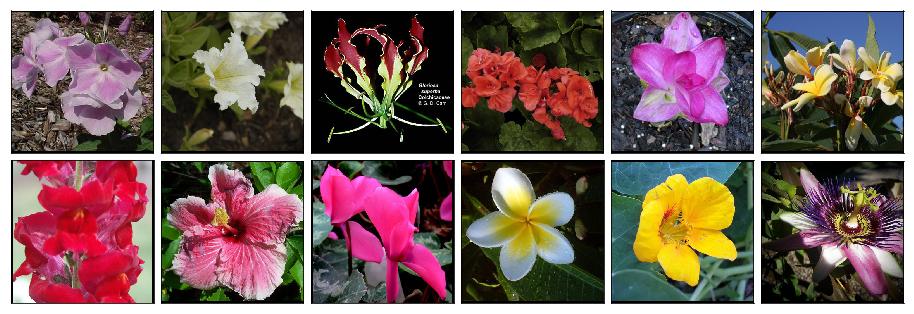

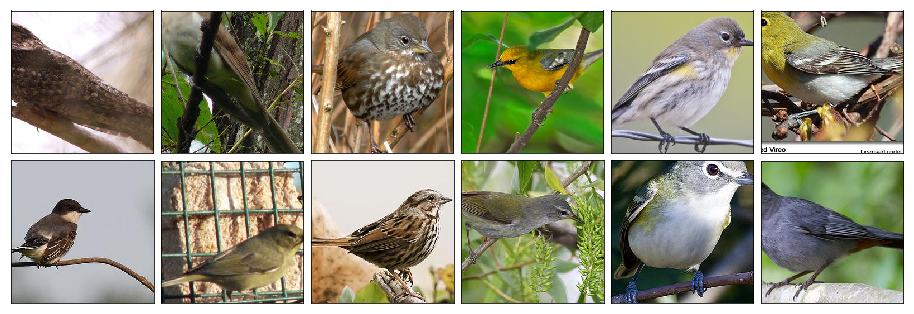

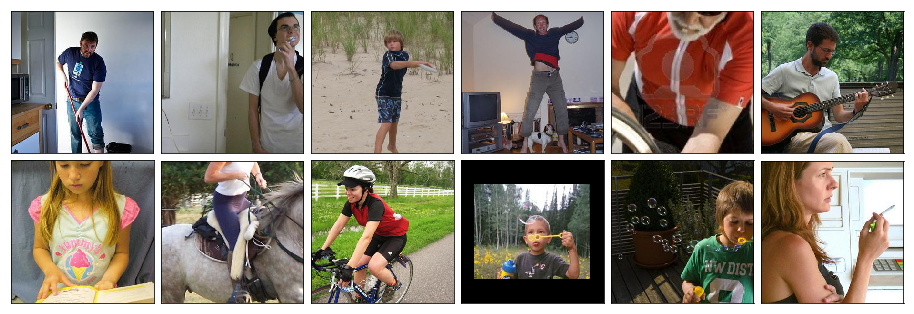

In [60]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import scipy.io
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import random

def show_images(dataset_folder, crop):
    images_classes = os.listdir(dataset_folder)
    images_paths = ['{}/{}/{}'.format(dataset_folder, class_, name) 
                    for class_ in images_classes
                    for name in os.listdir(dataset_folder + class_)]
    random.shuffle(images_paths)

    height = 2
    width = 6
    images = [transforms.functional.center_crop(Image.open(image_path), crop)
              for image_path in images_paths[:height * width]]


    fig = plt.figure(figsize=(16., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(height, width),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            left=False,
            top=False,         
            labelbottom=False,
            labelleft=False
        )

    plt.show()

show_images('./datasets/flower_data/train/', 512)
show_images('./datasets/birds_data/train/', 256)
show_images('./datasets/stanford_data/train/', 300)

In [6]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import Adam
from tqdm.notebook import tqdm
from IPython.display import clear_output

def plot_hist(loader, loss_hist, acc_hist):
    clear_output()
    print('Loss: {}'.format(loss_hist[-1]))
    print('Accuracy: {}'.format(acc_hist[-1]))
    with plt.xkcd():
        fig, ax = plt.subplots(1, 2, figsize=[16,8])
        ax[0].plot(loss_hist)
        ax[0].set_title('Loss')
        ax[1].plot(np.linspace(1, len(loss_hist), len(acc_hist)).astype(int), acc_hist, marker='+', markersize=20)
        ax[1].set_title('Accuracy')
        plt.show()
        
def count_accuracy(model, loader):
    preds = []
    true = []
    for data, labels in tqdm(loader, desc='Testing', leave=False):
        preds.extend(np.argmax(model(data.cuda()).detach().cpu().numpy(), axis=1))
        true.extend(labels.numpy())
    return (np.array(preds) == np.array(true)).mean()
        
    
def adjust_classifier(model, loader):
    num_classes = len(loader.dataset.classes)
    model.classifier[-1] = nn.Linear(4096, num_classes).cuda()
    
def fine_tune(loader, model, epochs=20, epochs_unchanged=3):
    model = copy.deepcopy(model)
    
    adjust_classifier(model, loader)

    optimizer = Adam(
        [{'params': model.classifier[:5].parameters(), 'lr': 1e-3 * 0.1},
        {'params': model.classifier[5:].parameters(), 'lr': 1e-3}],
    )
    loss_func = nn.CrossEntropyLoss()

    loss_hist = []
    acc_hist = []
    best_acc = 0
    best_model = copy.deepcopy(model)
    best_model_for = 0
    for epoch in range(epochs):
        for data, labels in tqdm(loader, desc='Epoch {}'.format(epoch + 1), leave=False):
            data = data.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            preds = model(data)
            loss = loss_func(preds, labels)
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())

        model.eval()
        acc_hist.append(count_accuracy(model, loader))
        model.train()
        plot_hist(loader, loss_hist, acc_hist)
        if acc_hist[-1] > best_acc:
            best_acc = acc_hist[-1]
            best_model = copy.deepcopy(model)
            best_model_for = 0
        else:
            best_model_for += 1
        if best_model_for >= epochs_unchanged:
            print('Best accuracy unchanged for {} epochs. Returning best model with accuracy {}.'
                  .format(epochs_unchanged, best_acc))
            break
    return best_model

In [7]:
flower_dataloaders, _, _ = get_flower_dataset()
birds_dataloaders, _, _ = get_birds_dataset()
stanford_dataloaders, _, _ = get_stanford_dataset()

In [8]:
import torchvision.models as tvm
FLOWER_MODEL_PATH = './vgg19_flower.pth'
BIRDS_MODEL_PATH = './vgg19_birds.pth'
STANFORD_MODEL_PATH = './vgg19_stanford.pth'
TRAIN = False

flower_model = tvm.vgg19(pretrained=True).cuda()
birds_model = tvm.vgg19(pretrained=True).cuda()
stanford_model = tvm.vgg19(pretrained=True).cuda()
if TRAIN:
    flower_model = fine_tune(flower_dataloaders['train'], flower_model)
    torch.save(flower_model.state_dict(), FLOWER_MODEL_PATH)
    birds_model = fine_tune(birds_dataloaders['train'], birds_model)
    torch.save(birds_model.state_dict(), BIRDS_MODEL_PATH)
    stanford_model = fine_tune(stanford_dataloaders['train'], stanford_model)
    torch.save(stanford_model.state_dict(), STANFORD_MODEL_PATH)
else:
    adjust_classifier(flower_model, flower_dataloaders['train'])
    flower_model.load_state_dict(torch.load(FLOWER_MODEL_PATH))
    flower_model.eval()
    print('Loaded model. Accuracy: {}'.format(count_accuracy(flower_model, flower_dataloaders['test'])))
    adjust_classifier(birds_model, birds_dataloaders['train'])
    birds_model.load_state_dict(torch.load(BIRDS_MODEL_PATH))
    birds_model.eval()
    print('Loaded model. Accuracy: {}'.format(count_accuracy(birds_model, birds_dataloaders['test'])))
    adjust_classifier(stanford_model, stanford_dataloaders['train'])
    stanford_model.load_state_dict(torch.load(STANFORD_MODEL_PATH))
    stanford_model.eval()
    print('Loaded model. Accuracy: {}'.format(count_accuracy(stanford_model, stanford_dataloaders['test'])))

HBox(children=(FloatProgress(value=0.0, description='Testing', max=26.0, style=ProgressStyle(description_width='initial')), HTML(value='')))

Loaded model. Accuracy: 0.8388278388278388


HBox(children=(FloatProgress(value=0.0, description='Testing', max=182.0, style=ProgressStyle(description_width='initial')), HTML(value='')))

Loaded model. Accuracy: 0.5390989124805801


HBox(children=(FloatProgress(value=0.0, description='Testing', max=173.0, style=ProgressStyle(description_width='initial')), HTML(value='')))

Loaded model. Accuracy: 0.7143890093998554


In [9]:
import copy

def svd(layer, rank, model=None, dataloader=None):
    """
    Creates model with regular svd applied
    :param layer: Layer to compress
    :param r: Number of singular vectors to keep (rank of the approximation)
    :param model: For compatibility
    :param dataloader: For compatibility
    :return result_model: Model with compressed fc layers
    """
    layer = copy.deepcopy(layer)
    W = layer.weight
    U, S, V = torch.svd(W, compute_uv=True)
    U_hat = U[:, :rank]
    S_hat = torch.diag(S[:rank])
    V_hat = V[:, :rank]
    W_hat = torch.mm(torch.mm(U_hat, S_hat), V_hat.t())
    layer.weight.data = W_hat
    return layer

In [10]:
def get_mean_x(dataloader, model, layer):
    X = []
    for data, labels in tqdm(dataloader, leave=False):
        x = data.cuda()
        cur_batch_size = x.size(0)
        for l in model.features:
            x = l(x)
        x = x.view(cur_batch_size, -1)
        for l in model.classifier:
            if l == layer:
                break
            x = l(x)
        X.append(x.detach().cpu().numpy())
    X = np.vstack(X)
    return X.mean(axis=0)


def svd_bc(layer, rank, model, dataloader, lambda_=1000):
    """
    Creates model with bias corrected svd applied
    :param model: Initial model without compression
    :param r: Number of singular vectors to keep (rank of the approximation)
    :return result_model: Model with compressed fc layers
    """
    mean_x = get_mean_x(dataloader, model, layer)
    layer = copy.deepcopy(layer)
    W = layer.weight
    U, S, V = torch.svd(W, compute_uv=True)
    U_hat = U[:, :rank]
    S_hat = torch.diag(S)[:rank, :rank]
    V_hat = V[:, :rank]
    W_hat = torch.mm(torch.mm(U_hat, S_hat), V_hat.t())
    
    b = layer.bias
    mean_x = torch.from_numpy(mean_x).view(-1, 1).cuda()
    b_hat = b + torch.mm(W - W_hat, mean_x).view(-1)
    layer.weight.data = W_hat
    layer.bias.data = b_hat
    return layer

In [11]:
def svd_dalr(layer, r, model, dataloader, lambda_=1000):
    """
    Creates model with DLAR applied
    :param layer: Layer to compress
    :param r: Number of singular vectors to keep (rank of the approximation)
    :param model: Full initial model
    :param dataloader: Dataloader for compression
    :return result_model: Model with compressed fc layers
    """
    X = []
    for data, labels in tqdm(dataloader, leave=False):
        x = data.cuda()
        cur_batch_size = x.size(0)
        for l in model.features:
            x = l(x)
        x = x.view(cur_batch_size, -1)
        for l in model.classifier:
            if l == layer:
                break
            x = l(x)
        X.append(x.detach().cpu().numpy())
    X = np.vstack(X)
    W = layer.weight.detach().cpu().numpy()
    Z = W @ X.T
    U, S, Vt = np.linalg.svd(Z)
    Uhat = U[:,:r]
    A = Uhat
    B = Uhat.T @ Z @ X @ np.linalg.inv(X.T @ X + lambda_ * np.eye(X.shape[1]))
    
    new_layer = copy.deepcopy(layer)
    new_layer.weight.data = torch.Tensor(A @ B).cuda()
    return new_layer

In [12]:
def count_compression_accuracy_fc7(model, rs, compression_func, dataloader, verbose=True):
    results = []
    for r in rs:
        new_model = copy.deepcopy(model)
        new_model.classifier[3] = compression_func(new_model.classifier[3], r, new_model, dataloader)
        new_model.eval()
        accuracy = count_accuracy(new_model, dataloader)
        results.append(accuracy)
        if verbose:
            print('Accuracy for r = {}:\t{}'.format(r, accuracy))
    return results

In [26]:
def printarr(arr):
    print('\t'.join('{:.2f}'.format(f) for f in arr))

0.67	0.76	0.78	0.79	0.80	0.80
0.68	0.76	0.79	0.79	0.80	0.80
0.75	0.78	0.79	0.80	0.80	0.79


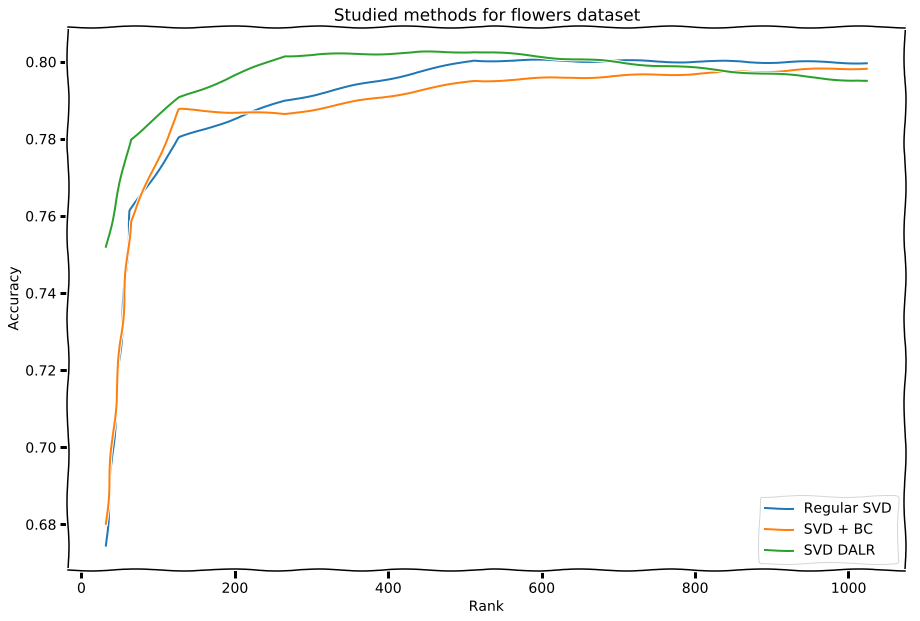

In [27]:
rs = [32, 64, 128, 265, 512, 1024]
flower_svd_result = count_compression_accuracy_fc7(flower_model, rs, svd, flower_dataloaders['train'], verbose=False)
flower_svd_bc_result = count_compression_accuracy_fc7(flower_model, rs, svd_bc, flower_dataloaders['train'], verbose=False)
flower_svd_dalr_result = count_compression_accuracy_fc7(flower_model, rs, svd_dalr, flower_dataloaders['train'], verbose=False)

printarr(flower_svd_result)
printarr(flower_svd_bc_result)
printarr(flower_svd_dalr_result)

with plt.xkcd():
    plt.figure(figsize=[15,10])
    plt.title('Studied methods for flowers dataset')
    plt.xlabel('Rank')
    plt.ylabel('Accuracy')
    plt.plot(rs, flower_svd_result, label='Regular SVD')
    plt.plot(rs, flower_svd_bc_result, label='SVD + BC')
    plt.plot(rs, flower_svd_dalr_result, label='SVD DALR')
    plt.legend()

0.37	0.45	0.48	0.53	0.54	0.54
0.38	0.47	0.49	0.51	0.54	0.53
0.46	0.50	0.51	0.53	0.53	0.54


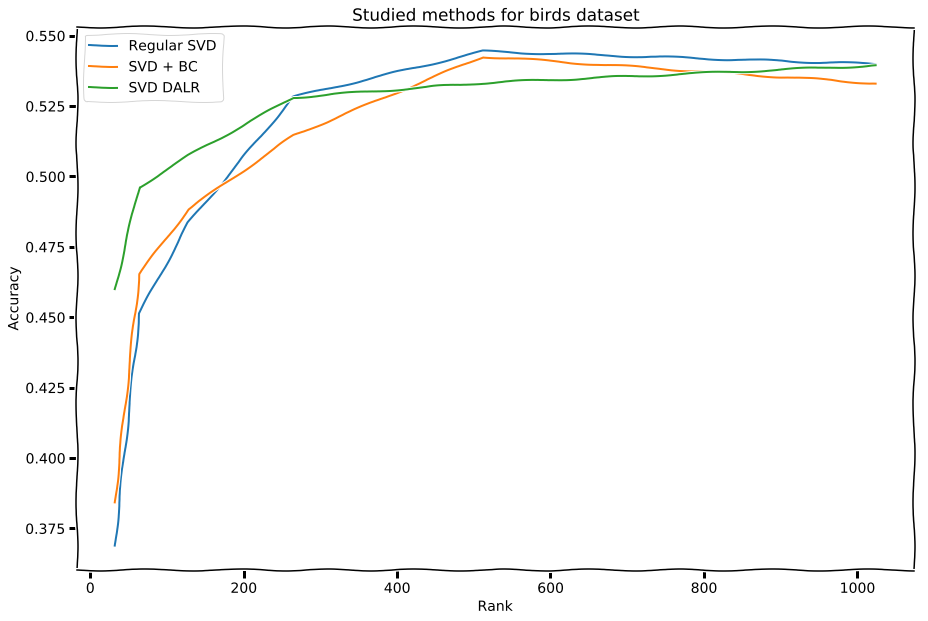

In [28]:
rs = [32, 64, 128, 265, 512, 1024]
birds_svd_result = count_compression_accuracy_fc7(birds_model, rs, svd, birds_dataloaders['train'], verbose=False)
birds_svd_bc_result = count_compression_accuracy_fc7(birds_model, rs, svd_bc, birds_dataloaders['train'], verbose=False)
birds_svd_dalr_result = count_compression_accuracy_fc7(birds_model, rs, svd_dalr, birds_dataloaders['train'], verbose=False)

printarr(birds_svd_result)
printarr(birds_svd_bc_result)
printarr(birds_svd_dalr_result)

with plt.xkcd():
    plt.figure(figsize=[15,10])
    plt.title('Studied methods for birds dataset')
    plt.xlabel('Rank')
    plt.ylabel('Accuracy')
    plt.plot(rs, birds_svd_result, label='Regular SVD')
    plt.plot(rs, birds_svd_bc_result, label='SVD + BC')
    plt.plot(rs, birds_svd_dalr_result, label='SVD DALR')
    plt.legend()

0.53	0.59	0.61	0.61	0.65	0.65
0.54	0.60	0.61	0.62	0.64	0.65
0.57	0.61	0.61	0.61	0.62	0.63


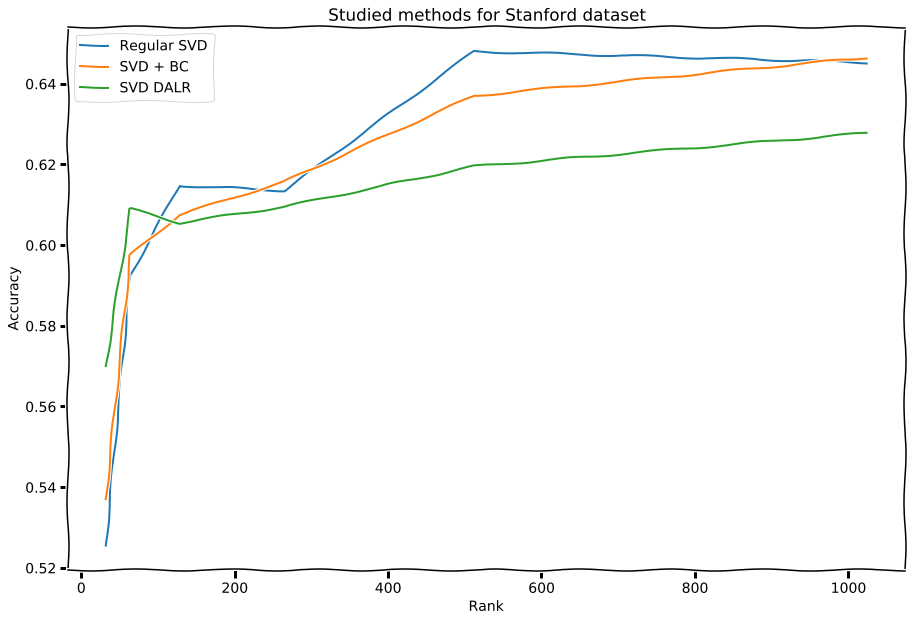

In [29]:
rs = [32, 64, 128, 265, 512, 1024]
stanford_svd_result = count_compression_accuracy_fc7(stanford_model, rs, svd, stanford_dataloaders['train'], verbose=False)
stanford_svd_bc_result = count_compression_accuracy_fc7(stanford_model, rs, svd_bc, stanford_dataloaders['train'], verbose=False)
stanford_svd_dalr_result = count_compression_accuracy_fc7(stanford_model, rs, svd_dalr, stanford_dataloaders['train'], verbose=False)

printarr(stanford_svd_result)
printarr(stanford_svd_bc_result)
printarr(stanford_svd_dalr_result)

with plt.xkcd():
    plt.figure(figsize=[15,10])
    plt.title('Studied methods for Stanford dataset')
    plt.xlabel('Rank')
    plt.ylabel('Accuracy')
    plt.plot(rs, stanford_svd_result, label='Regular SVD')
    plt.plot(rs, stanford_svd_bc_result, label='SVD + BC')
    plt.plot(rs, stanford_svd_dalr_result, label='SVD DALR')
    plt.legend()